In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
import re
from re import findall

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
df_trainval

,dist_low_30,in_sess_time,dist_low_60,dist_low_28,eng_ema_cross_up,minute_time,rsi,hour_time,z_vwap_dev,dist_high_30,...,bb_w_z_60,minus_di_30,volume_z_30,macd_diff_z_90,plus_di_60,close_raw,signal,pred_signal,ask,bid
2009-01-02 12:30:00,0.000000,0.0,0.000000,0.000000,0.0,0.147157,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000143,0.201541,3.070103,3.069182
2009-01-02 12:31:00,0.000000,0.0,0.000000,0.000000,0.0,0.148829,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000153,0.201937,3.070103,3.069182
2009-01-02 12:32:00,0.000000,0.0,0.000000,0.000000,0.0,0.150502,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000163,0.202283,3.070103,3.069182
2009-01-02 12:33:00,0.000000,0.0,0.000000,0.000000,0.0,0.152174,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000173,0.202436,3.070103,3.069182
2009-01-02 12:34:00,0.000000,0.0,0.000000,0.000000,0.0,0.153846,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000182,0.202492,3.070103,3.069182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 20:56:00,0.183189,1.0,0.131679,0.190111,1.0,0.993311,0.583460,0.9,0.317730,0.044131,...,0.539532,0.172834,0.374268,0.530514,0.216956,131.730000,0.036463,0.114993,131.749760,131.710240
2022-12-23 20:57:00,0.210647,1.0,0.151416,0.218606,1.0,0.994983,0.616177,0.9,0.468530,0.016540,...,0.531617,0.171265,0.444313,0.527930,0.213317,131.805000,0.033832,0.127890,131.824771,131.785229
2022-12-23 20:58:00,0.219793,1.0,0.157990,0.228097,1.0,0.996655,0.626702,0.9,0.484463,0.007350,...,0.520810,0.167707,0.415307,0.525205,0.214583,131.830000,0.028223,0.127704,131.849775,131.810226
2022-12-23 20:59:00,0.230763,1.0,0.165876,0.239482,1.0,0.998328,0.639478,0.9,0.453982,0.000000,...,0.510832,0.161685,0.665962,0.523102,0.216984,131.860000,0.024628,0.132516,131.879779,131.840221


In [4]:
# Pre-compute per-day slices once
groups = df_trainval.groupby(df_trainval.index.normalize())
prun_perc = 50
report_interval = 50

_num_re = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?")
_findall = _num_re.findall

def objective(trial: optuna.Trial) -> float:
    
    sign_smoothwin = trial.suggest_categorical("sign_smoothwin", [1])
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1,-3])
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_reg.isoformat(), params.sess_start_pred.isoformat()]))
    buy_thresh     = trial.suggest_float("buy_thresh", 0.03, 0.3)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.03, 0.3)

    print('-----------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Simulate trading using parameters ==> sign_smoothwin:',sign_smoothwin,'sellmin_idx:',sellmin_idx,'sess_start:',sess_start,'buy_thresh:',
          round(buy_thresh,4),'trailstop_pct:',round(trailstop_pct,4))
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        # Causal smoothing of the raw pred_signal
        if sign_smoothwin > 1:
            df_day["pred_signal"] = (
                df_day["pred_signal"]
                  .rolling(window=sign_smoothwin, min_periods=1)
                  .mean()
            )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_day,
            col_signal        = "pred_signal",
            col_action        = "pred_action",
            col_price         = "close_raw",
            buy_thresh        = buy_thresh,
            trailstop_pct     = trailstop_pct,
            sellmin_idx       = sellmin_idx,
            sess_start        = sess_start
            )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            day               = day,
            df                = df_actions,
            col_action        = "pred_action",
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 
        
        # if day.to_period("M").strftime("%Y-%m") == params.month_to_check: ####################
        #     print('day', day, 'stats', stats, 'strategy_val', strategy_val)

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 13:30:00 buy_thresh: 0.202 trailstop_pct: 0.1253


Trial 0: 100%|██████████| 3520/3520 [00:31<00:00, 110.82it/s]


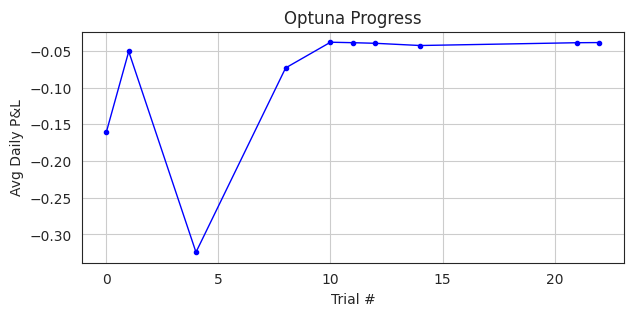

[I 2025-12-01 10:54:52,660] Trial 0 finished with value: -0.1608. Best is trial 0 with value: -0.1608.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.257 trailstop_pct: 0.2327


Trial 1: 100%|██████████| 3520/3520 [00:35<00:00, 98.09it/s] 


[I 2025-12-01 10:55:28,883] Trial 1 finished with value: -0.0508. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.1447 trailstop_pct: 0.0513


Trial 2:  26%|██▌       | 899/3520 [00:10<00:29, 87.92it/s] 


[PRUNE] value=-0.121908 thr=-0.042004
[I 2025-12-01 10:55:39,457] Trial 2 finished with value: -0.1219. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1137 trailstop_pct: 0.1499


Trial 3:  25%|██▌       | 896/3520 [00:11<00:33, 78.95it/s]


[PRUNE] value=-0.131312 thr=-0.042004
[I 2025-12-01 10:55:51,117] Trial 3 finished with value: -0.1313. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.057 trailstop_pct: 0.1011


Trial 4: 100%|██████████| 3520/3520 [00:45<00:00, 77.74it/s]


[I 2025-12-01 10:56:36,794] Trial 4 finished with value: -0.3242. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 14:30:00 buy_thresh: 0.1693 trailstop_pct: 0.235


Trial 5:  25%|██▌       | 891/3520 [00:10<00:31, 83.18it/s]


[PRUNE] value=-0.197529 thr=-0.063768
[I 2025-12-01 10:56:47,823] Trial 5 finished with value: -0.1975. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 14:30:00 buy_thresh: 0.1509 trailstop_pct: 0.161


Trial 6:  26%|██▌       | 899/3520 [00:10<00:29, 87.82it/s] 


[PRUNE] value=-0.082392 thr=-0.063768
[I 2025-12-01 10:56:58,380] Trial 6 finished with value: -0.0824. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.0688 trailstop_pct: 0.0951


Trial 7:  25%|██▌       | 894/3520 [00:12<00:37, 69.75it/s]


[PRUNE] value=-0.194888 thr=-0.063768
[I 2025-12-01 10:57:11,549] Trial 7 finished with value: -0.1949. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2707 trailstop_pct: 0.0623


Trial 8: 100%|██████████| 3520/3520 [00:38<00:00, 92.15it/s] 


[I 2025-12-01 10:57:50,077] Trial 8 finished with value: -0.0732. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.1829 trailstop_pct: 0.0515


Trial 9:  25%|██▌       | 895/3520 [00:10<00:29, 89.31it/s] 


[PRUNE] value=-0.101261 thr=-0.047412
[I 2025-12-01 10:58:00,414] Trial 9 finished with value: -0.1013. Best is trial 1 with value: -0.0508.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2933 trailstop_pct: 0.2953


Trial 10: 100%|██████████| 3520/3520 [00:34<00:00, 101.98it/s]


[I 2025-12-01 10:58:35,285] Trial 10 finished with value: -0.0382. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2932 trailstop_pct: 0.2963


Trial 11: 100%|██████████| 3520/3520 [00:39<00:00, 90.25it/s] 


[I 2025-12-01 10:59:14,655] Trial 11 finished with value: -0.0388. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2968 trailstop_pct: 0.2963


Trial 12: 100%|██████████| 3520/3520 [00:39<00:00, 89.06it/s] 


[I 2025-12-01 10:59:54,524] Trial 12 finished with value: -0.0396. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2309 trailstop_pct: 0.2977


Trial 13:  25%|██▌       | 892/3520 [00:10<00:30, 86.67it/s] 


[PRUNE] value=-0.026453 thr=-0.020241
[I 2025-12-01 11:00:05,153] Trial 13 finished with value: -0.0265. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2967 trailstop_pct: 0.2379


Trial 14: 100%|██████████| 3520/3520 [00:38<00:00, 91.77it/s] 


[I 2025-12-01 11:00:44,029] Trial 14 finished with value: -0.0427. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2319 trailstop_pct: 0.2652


Trial 15:  25%|██▌       | 895/3520 [00:12<00:36, 71.01it/s] 


[PRUNE] value=-0.028739 thr=-0.018361
[I 2025-12-01 11:00:56,997] Trial 15 finished with value: -0.0287. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2503 trailstop_pct: 0.2057


Trial 16:  26%|██▌       | 899/3520 [00:09<00:28, 91.44it/s] 


[PRUNE] value=-0.028089 thr=-0.018361
[I 2025-12-01 11:01:07,169] Trial 16 finished with value: -0.0281. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2789 trailstop_pct: 0.2045


Trial 17:  25%|██▌       | 891/3520 [00:09<00:27, 95.56it/s] 


[PRUNE] value=-0.020493 thr=-0.018361
[I 2025-12-01 11:01:16,821] Trial 17 finished with value: -0.0205. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 13:30:00 buy_thresh: 0.2218 trailstop_pct: 0.2684


Trial 18:  26%|██▌       | 899/3520 [00:10<00:30, 85.35it/s] 


[PRUNE] value=-0.032816 thr=-0.018361
[I 2025-12-01 11:01:27,763] Trial 18 finished with value: -0.0328. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0966 trailstop_pct: 0.2027


Trial 19:  25%|██▌       | 896/3520 [00:12<00:36, 72.03it/s]


[PRUNE] value=-0.121684 thr=-0.018361
[I 2025-12-01 11:01:40,502] Trial 19 finished with value: -0.1217. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2054 trailstop_pct: 0.2702


Trial 20:  26%|██▌       | 898/3520 [00:09<00:29, 90.41it/s] 


[PRUNE] value=-0.058821 thr=-0.018361
[I 2025-12-01 11:01:50,714] Trial 20 finished with value: -0.0588. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2988 trailstop_pct: 0.2996


Trial 21: 100%|██████████| 3520/3520 [00:30<00:00, 116.66it/s]


[I 2025-12-01 11:02:21,296] Trial 21 finished with value: -0.0389. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.299 trailstop_pct: 0.2993


Trial 22: 100%|██████████| 3520/3520 [00:32<00:00, 107.35it/s]


[I 2025-12-01 11:02:54,430] Trial 22 finished with value: -0.0386. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2704 trailstop_pct: 0.2704


Trial 23:  25%|██▌       | 893/3520 [00:07<00:23, 113.89it/s]


[PRUNE] value=-0.018372 thr=-0.015519
[I 2025-12-01 11:03:02,605] Trial 23 finished with value: -0.0184. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2534 trailstop_pct: 0.2442


Trial 24:  25%|██▌       | 887/3520 [00:08<00:25, 104.72it/s]


[PRUNE] value=-0.025394 thr=-0.015519
[I 2025-12-01 11:03:11,392] Trial 24 finished with value: -0.0254. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2738 trailstop_pct: 0.2822


Trial 25:  25%|██▌       | 897/3520 [00:08<00:24, 107.39it/s]


[PRUNE] value=-0.017547 thr=-0.015519
[I 2025-12-01 11:03:20,067] Trial 25 finished with value: -0.0175. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2421 trailstop_pct: 0.2442


Trial 26:  25%|██▌       | 896/3520 [00:08<00:24, 105.45it/s]


[PRUNE] value=-0.028101 thr=-0.015519
[I 2025-12-01 11:03:28,893] Trial 26 finished with value: -0.0281. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2878 trailstop_pct: 0.2173


Trial 27:  25%|██▌       | 890/3520 [00:07<00:22, 119.09it/s]


[PRUNE] value=-0.018399 thr=-0.015519
[I 2025-12-01 11:03:36,703] Trial 27 finished with value: -0.0184. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 13:30:00 buy_thresh: 0.2161 trailstop_pct: 0.1804


Trial 28:  25%|██▌       | 897/3520 [00:09<00:27, 97.11it/s] 


[PRUNE] value=-0.043516 thr=-0.015519
[I 2025-12-01 11:03:46,253] Trial 28 finished with value: -0.0435. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2622 trailstop_pct: 0.2562


Trial 29:  25%|██▌       | 894/3520 [00:10<00:30, 86.95it/s] 


[PRUNE] value=-0.020341 thr=-0.015519
[I 2025-12-01 11:03:56,846] Trial 29 finished with value: -0.0203. Best is trial 10 with value: -0.0382.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -3 sess_start: 13:30:00 buy_thresh: 0.1932 trailstop_pct: 0.2792


Trial 30:   3%|▎         | 114/3520 [00:01<00:40, 84.35it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

n_trials = 600
n_jobs = 1

pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=1, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.cleanup_callback, plots.plot_callback, plots.save_results_callback, plots.short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")